In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import unicodedata
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [38]:
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('ja_ginza')

In [3]:
train_df = pd.read_csv('../data/train.tsv', sep='\t')
test_df = pd.read_csv('../data/test.tsv', sep='\t')

In [4]:
train_df

,text,label
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,3
2,早寝するつもりが飲み物がなくなりコンビニへ｡ん､今日、風が涼しいな。,1
3,眠い、眠れない。,0
4,ただいま? って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,2
...,...,...
39995,ジョージア移住系ブロガーになるって言っても、月間ボリューム100～1000かいな！,0
39996,イギリスは6ヶ月未満、ビザなし滞在OK。凄い！,0
39997,カナダは、6ヶ月以内の観光の場合、ビザなし滞在OK。凄い！,0
39998,なぜ有料noteが重宝されているのかを解説したいが、需要がないので止めておこう。,0


In [5]:
test_df

,text,label
0,福岡に移住して、特に不満はない。\nけれど、慣れて来たので、他の街にも行ってみたくなってきて...,0
1,うまくいった時の慢心には注意Σ(・∀・；),0
2,お金持ちではなかったので、自分でカードゲームを作りだしたりして遊んでいた。\n\nその時の楽...,0
3,飲み屋でしか聞けなかったような話って実はYouTubeで需要がある。,0
4,①まずやってみる\n②疑問が出てきてから、その疑問解決のための教材を買う\n\n↑教材が高い...,0
...,...,...
3195,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\...,0
3196,ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過...,1
3197,朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎて...,2
3198,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を...,2


In [6]:
EMBEDDING_DIM = nlp.vocab.vectors_length
nlp.vocab.set_vector("@pad@", np.zeros(EMBEDDING_DIM))
nlp.vocab.set_vector("@unk@", np.zeros(EMBEDDING_DIM))

In [7]:
def preprocess_text(text: str) -> str:
  text = unicodedata.normalize("NFKC", text)
  text = re.sub(r"\s+", " ", text)
  text = text.lower()
  return text

def text2seq(text: str, padded_len: int) -> np.ndarray:
  doc = nlp(preprocess_text(text))
  assert len(doc) <= padded_len
  seq = np.zeros(padded_len, dtype=np.int64)
  head = padded_len - len(doc)
  seq[:head] = nlp.vocab["@pad@"].rank
  for i, token in enumerate(doc):
    if token.has_vector:
      seq[head + i] = token.rank
    else:
      seq[head + i] = nlp.vocab["@unk@"].rank
  return seq

In [8]:
PADDED_LEN = 160
X_train = np.stack([text2seq(text, PADDED_LEN) for text in tqdm(train_df["text"])])
X_test = np.stack([text2seq(text, PADDED_LEN) for text in tqdm(test_df["text"])])

100%|██████████| 3200/3200 [00:41<00:00, 76.27it/s] 


In [9]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.as_tensor(train_df["label"].values, dtype=torch.int64)
y_test = torch.as_tensor(test_df["label"].values, dtype=torch.int64)

In [10]:
torch.save(X_train, '../data/X_train.pt')
torch.save(X_test, '../data/X_test.pt')
torch.save(y_train, '../data/y_train.pt')
torch.save(y_test, '../data/y_test.pt')

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

In [13]:
VOCAB_SIZE = len(nlp.vocab.vectors)
embed_weights = torch.FloatTensor(nlp.vocab.vectors.data)
embed = nn.Embedding.from_pretrained(embed_weights, freeze=True)

In [30]:
N_CLASSES = 4

class LSTMClassfier(nn.Module):
  def __init__(self, embed: nn.Embedding, hidden_dim: int):
    super().__init__()
    self.embed = embed
    self.lstm = nn.LSTM(EMBEDDING_DIM, hidden_dim, batch_first=True)
    self.linear = nn.Linear(hidden_dim, N_CLASSES)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.embed(x)
    _, (h, _) = self.lstm(x)
    return self.linear(h.squeeze(0))

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
def train(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn: nn.Module) -> tuple[float, float]:
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.train()
  train_loss, correct = 0, 0
  for i, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Compute prediction error
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred.squeeze(), y)

    train_loss += loss.item()
    correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      loss, current = loss.item(), (i + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  train_loss /= num_batches
  correct /= size

  return train_loss, correct

def test(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module) -> tuple[float, float]:
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      test_loss += loss_fn(y_pred.squeeze(), y).item()
      correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  return test_loss, correct

In [35]:
model = LSTMClassfier(embed, 128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

In [24]:
X, y = next(iter(train_loader))
y_pred = model(X)
y_pred.shape

torch.Size([1, 32, 4])

In [25]:
X.shape

torch.Size([32, 160])

In [29]:
with torch.no_grad():
  x = model.embed(X)
  print(x.shape)
  _, (h, _) = model.lstm(x)
  print(h.shape)
  y_pred = model.linear(h)
  print(y_pred.shape)

torch.Size([32, 160, 300])
torch.Size([1, 32, 128])
torch.Size([1, 32, 4])


In [37]:
N_EPOCHS = 10
hist = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
for t in range(N_EPOCHS):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
  val_loss, val_accuracy = test(model, val_loader, loss_fn)

  hist["train_loss"].append(train_loss)
  hist["train_accuracy"].append(train_accuracy)
  hist["val_loss"].append(val_loss)
  hist["val_accuracy"].append(val_accuracy)

  print("Epoch Summary:")
  print(f"train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
  print(f"train_accuracy: {train_accuracy:>7f}, val_accuracy: {val_accuracy:>7f}")

Epoch 1
-------------------------------
loss: 1.386708  [   32/32000]
loss: 1.162359  [ 3232/32000]
loss: 1.144235  [ 6432/32000]
loss: 1.194499  [ 9632/32000]
loss: 0.846555  [12832/32000]
loss: 1.142679  [16032/32000]
loss: 0.901681  [19232/32000]
loss: 1.037951  [22432/32000]
loss: 0.956357  [25632/32000]
loss: 0.991982  [28832/32000]
Epoch Summary:
train_loss: 1.049756, val_loss: 1.009792
train_accuracy: 0.599781, val_accuracy: 0.611375
Epoch 2
-------------------------------
loss: 0.776479  [   32/32000]
loss: 1.140560  [ 3232/32000]
loss: 0.788164  [ 6432/32000]
loss: 1.147479  [ 9632/32000]
loss: 1.095516  [12832/32000]
loss: 1.088614  [16032/32000]
loss: 1.004690  [19232/32000]
loss: 0.720584  [22432/32000]
loss: 0.889550  [25632/32000]
loss: 1.207627  [28832/32000]
Epoch Summary:
train_loss: 1.000242, val_loss: 0.998923
train_accuracy: 0.612969, val_accuracy: 0.613500
Epoch 3
-------------------------------
loss: 0.968534  [   32/32000]
loss: 0.803001  [ 3232/32000]
loss: 1.05

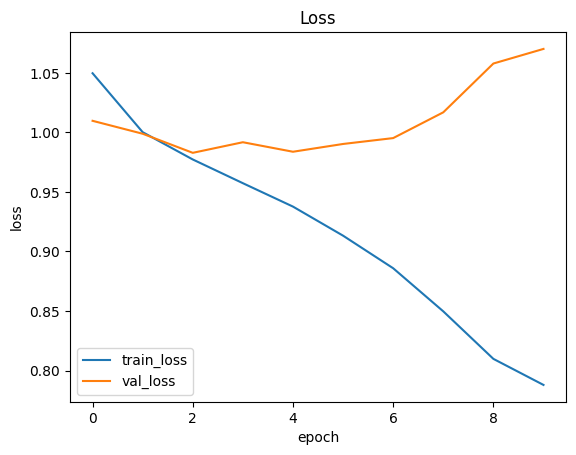

In [39]:
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

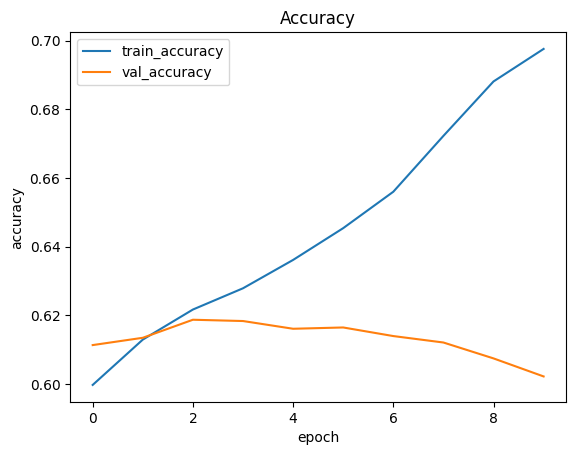

In [40]:
plt.plot(hist["train_accuracy"], label="train_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()